# Analysis
The following cells are where both EDA and models such as PCA & K means clustering are applied.

## Setup

In [1]:
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from empowered.utils.helpers import get_sql_client

/home/nasir/anaconda3/envs/empowered/lib/python3.12/contextlib.py:137: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  return next(self.gen)


In [2]:
sql_client = get_sql_client()
# pd.set_option('display.max_rows', None)   # Show all rows
# pd.set_option('display.max_columns', None) # Show all columns
# pd.set_option('display.width', 1000)      # Wider display
# pd.set_option('display.max_colwidth', None)

In [3]:
# estimates = sql_client.execute("SELECT * FROM CensusPivot;")
estimates_df = pd.read_csv("/home/nasir/Documents/empowered/data/pivot.csv")
estimates_df.head()

,place_fips,state_fips,B14007_005E,B17001_049E,B15003_018E,B19001_016E,B17001_024E,B17001_027E,B09010_010E,B15003_022E,...,B17001_020E,B14006_002E,B14006_005E,B14006_015E,B19001_007E,B19013_001E,B25070_007E,B17001_046E,B09010_011E,B15003_007E
0,9424,1,8.0,52.0,51.0,0.0,0.0,16.0,119.0,7.0,...,10.0,234.0,9.0,6.0,14.0,24643.0,11.0,327.0,23.0,0.0
1,75940,4,0.0,0.0,21.0,106.0,0.0,0.0,66.0,410.0,...,0.0,99.0,0.0,0.0,60.0,66349.0,0.0,614.0,12.0,0.0
2,70040,4,4.0,21.0,29.0,11.0,0.0,8.0,34.0,164.0,...,0.0,94.0,0.0,0.0,58.0,42396.0,0.0,397.0,0.0,0.0
3,70882,6,360.0,838.0,465.0,241.0,420.0,238.0,3428.0,936.0,...,348.0,5405.0,86.0,325.0,537.0,40815.0,303.0,8873.0,581.0,136.0
4,29140,5,0.0,12.0,3.0,3.0,2.0,4.0,0.0,25.0,...,0.0,47.0,0.0,0.0,8.0,38661.0,0.0,58.0,0.0,0.0


## EDA

The `estimates_df` data has form:
  - row --> place
  - col --> variable
  - row, col --> estimate for variable given the place

Many variables are similar to each other, so in our analysis we expect high correlations among many of these variables. For example, B14007_00E (Total Population 3 years and over) is a subset of the variable B1003_001E (Total Population Estimate). However, B14007_00E provides additional information about the population, i.e. we can compare how young different places are. As a result, I do *not* drop any columns or variables for this very reason, as I believe the redundancy will *not* negatively affect the results, but rather bolster them.

Nonetheless, larger population places like New York CIty will dominate certain features (i.e. B1003_001E) so we must normalize all count/totals/population variables by the total population or B1003_001E. Additionally, we standardize all of the variables so values such as populations do not outweight variables like B19013_001E or Median household income,

In [4]:
# estimates_df_pivot = estimates_df.pivot_table(
#     index=['place_fips', 'state_fips'],
#     columns='variable_id',
#     values='estimate'
# ).reset_index()
# estimates_df_pivot.columns.name = None

# estimates_df_pivot.head(1)

In [5]:
def view_irreg(df, scale_cols):
    """
    Inspect a DataFrame for irregular values including:
    - NaNs
    - sentinel value -666666666
    - infinities (+inf, -inf)
    """

    print("\n==== Missing Values (NaNs) per Column ====")
    print(df.isna().sum())

    print("\n==== Sentinel Values (-666666666) per Column ====")
    print((df == -666666666).sum())

    # restrict to scale columns
    X = df[scale_cols]

    print("\n==== Any infinities in scale_cols? ====")
    has_inf = np.isinf(X.to_numpy()).any()
    print(has_inf)

    print("\n==== Count of infinities per column ====")
    inf_counts = np.isinf(X).sum()
    print(inf_counts[inf_counts > 0])

    print("\n==== Columns containing infinities ====")
    print(list(inf_counts[inf_counts > 0].index))

    print("\n==== Rows containing infinities ====")
    rows_with_inf = np.isinf(X).any(axis=1)
    print(X[rows_with_inf])

In [6]:
scale_cols = [col for col in estimates_df.columns if col not in ['place_fips', 'state_fips']]
view_irreg(estimates_df, scale_cols=scale_cols)


==== Missing Values (NaNs) per Column ====
place_fips     0
state_fips     0
B14007_005E    0
B17001_049E    2
B15003_018E    1
              ..
B19013_001E    2
B25070_007E    2
B17001_046E    2
B09010_011E    2
B15003_007E    1
Length: 179, dtype: int64

==== Sentinel Values (-666666666) per Column ====
place_fips       0
state_fips       0
B14007_005E      0
B17001_049E      0
B15003_018E      0
              ... 
B19013_001E    465
B25070_007E      0
B17001_046E      0
B09010_011E      0
B15003_007E      0
Length: 179, dtype: int64

==== Any infinities in scale_cols? ====
False

==== Count of infinities per column ====
Series([], dtype: int64)

==== Columns containing infinities ====
[]

==== Rows containing infinities ====
Empty DataFrame
Columns: [B14007_005E, B17001_049E, B15003_018E, B19001_016E, B17001_024E, B17001_027E, B09010_010E, B15003_022E, B14006_004E, B17001_058E, B14007_001E, B14007_016E, B17001_035E, B17001_009E, B14007_017E, B15003_006E, B15003_009E, B19001_017E, B

In [7]:
def fix_irreg(df):
    """
    Fix irregular values in the DataFrame by:
    - Replacing sentinel value -666666666 with 0
    - Replacing infinities (+inf, -inf) with 0
    - Filling NaNs with 0
    """
    df = df.replace(-666666666, 0)
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    return df


In [8]:

estimates_df = fix_irreg(estimates_df)

The Census API treats -666666666 as a placeholder, therefore we are converting it to 0 so it does not skew any points. Seems most of these place holders were for the median household income variable.

In [9]:
view_irreg(estimates_df, scale_cols=scale_cols)


==== Missing Values (NaNs) per Column ====
place_fips     0
state_fips     0
B14007_005E    0
B17001_049E    0
B15003_018E    0
              ..
B19013_001E    0
B25070_007E    0
B17001_046E    0
B09010_011E    0
B15003_007E    0
Length: 179, dtype: int64

==== Sentinel Values (-666666666) per Column ====
place_fips     0
state_fips     0
B14007_005E    0
B17001_049E    0
B15003_018E    0
              ..
B19013_001E    0
B25070_007E    0
B17001_046E    0
B09010_011E    0
B15003_007E    0
Length: 179, dtype: int64

==== Any infinities in scale_cols? ====
False

==== Count of infinities per column ====
Series([], dtype: int64)

==== Columns containing infinities ====
[]

==== Rows containing infinities ====
Empty DataFrame
Columns: [B14007_005E, B17001_049E, B15003_018E, B19001_016E, B17001_024E, B17001_027E, B09010_010E, B15003_022E, B14006_004E, B17001_058E, B14007_001E, B14007_016E, B17001_035E, B17001_009E, B14007_017E, B15003_006E, B15003_009E, B19001_017E, B17001_025E, B25070_008

In [10]:
estimates_df_norm = estimates_df.copy()

pop_col = 'B01003_001E'

# List of count variables to normalize by population
count_vars = [
    # Children & Public Assistance
    'B09010_001E', 'B09010_002E', 'B09010_003E', 'B09010_004E',
    'B09010_005E', 'B09010_006E', 'B09010_007E', 'B09010_008E',
    'B09010_009E', 'B09010_010E', 'B09010_011E', 'B09010_012E',
    'B09010_013E',
    
    # School Enrollment
    'B14007_001E', 'B14007_002E', 'B14007_003E', 'B14007_004E',
    'B14007_005E', 'B14007_006E', 'B14007_007E', 'B14007_008E',
    'B14007_009E', 'B14007_010E', 'B14007_011E', 'B14007_012E',
    'B14007_013E', 'B14007_014E', 'B14007_015E', 'B14007_016E',
    'B14007_017E', 'B14007_018E', 'B14007_019E',
    
    # Poverty Status by School Enrollment
    'B14006_001E', 'B14006_002E', 'B14006_003E', 'B14006_004E',
    'B14006_005E', 'B14006_006E', 'B14006_007E', 'B14006_008E',
    'B14006_009E', 'B14006_010E', 'B14006_011E', 'B14006_012E',
    'B14006_013E', 'B14006_014E', 'B14006_015E', 'B14006_016E',
    'B14006_017E', 'B14006_018E', 'B14006_019E', 'B14006_020E',
    'B14006_021E',
    
    # Poverty Status by Sex and Age
    'B17001_001E', 'B17001_002E', 'B17001_003E', 'B17001_004E',
    'B17001_005E', 'B17001_006E', 'B17001_007E', 'B17001_008E',
    'B17001_009E', 'B17001_010E', 'B17001_011E', 'B17001_012E',
    'B17001_013E', 'B17001_014E', 'B17001_015E', 'B17001_016E',
    'B17001_017E', 'B17001_018E', 'B17001_019E', 'B17001_020E',
    'B17001_021E', 'B17001_022E', 'B17001_023E', 'B17001_024E',
    'B17001_025E', 'B17001_026E', 'B17001_027E', 'B17001_028E'
]

In [11]:
# apply normalization
for col in count_vars:
    if col in estimates_df_norm.columns:
        estimates_df_norm[col] = estimates_df_norm[col] / estimates_df_norm[pop_col]

In [12]:
estimates_df_norm = fix_irreg(estimates_df_norm)

In [13]:
view_irreg(estimates_df_norm, scale_cols=scale_cols)


==== Missing Values (NaNs) per Column ====
place_fips     0
state_fips     0
B14007_005E    0
B17001_049E    0
B15003_018E    0
              ..
B19013_001E    0
B25070_007E    0
B17001_046E    0
B09010_011E    0
B15003_007E    0
Length: 179, dtype: int64

==== Sentinel Values (-666666666) per Column ====
place_fips     0
state_fips     0
B14007_005E    0
B17001_049E    0
B15003_018E    0
              ..
B19013_001E    0
B25070_007E    0
B17001_046E    0
B09010_011E    0
B15003_007E    0
Length: 179, dtype: int64

==== Any infinities in scale_cols? ====
False

==== Count of infinities per column ====
Series([], dtype: int64)

==== Columns containing infinities ====
[]

==== Rows containing infinities ====
Empty DataFrame
Columns: [B14007_005E, B17001_049E, B15003_018E, B19001_016E, B17001_024E, B17001_027E, B09010_010E, B15003_022E, B14006_004E, B17001_058E, B14007_001E, B14007_016E, B17001_035E, B17001_009E, B14007_017E, B15003_006E, B15003_009E, B19001_017E, B17001_025E, B25070_008

In [14]:
estimates_df_norm.head()

,place_fips,state_fips,B14007_005E,B17001_049E,B15003_018E,B19001_016E,B17001_024E,B17001_027E,B09010_010E,B15003_022E,...,B17001_020E,B14006_002E,B14006_005E,B14006_015E,B19001_007E,B19013_001E,B25070_007E,B17001_046E,B09010_011E,B15003_007E
0,9424,1,0.008667,52.0,51.0,0.0,0.000000,0.017335,0.128927,7.0,...,0.010834,0.253521,0.009751,0.006501,14.0,24643.0,11.0,327.0,0.024919,0.0
1,75940,4,0.000000,0.0,21.0,106.0,0.000000,0.000000,0.048000,410.0,...,0.000000,0.072000,0.000000,0.000000,60.0,66349.0,0.0,614.0,0.008727,0.0
2,70040,4,0.004228,21.0,29.0,11.0,0.000000,0.008457,0.035941,164.0,...,0.000000,0.099366,0.000000,0.000000,58.0,42396.0,0.0,397.0,0.000000,0.0
3,70882,6,0.014590,838.0,465.0,241.0,0.017021,0.009645,0.138926,936.0,...,0.014103,0.219048,0.003485,0.013171,537.0,40815.0,303.0,8873.0,0.023546,136.0
4,29140,5,0.000000,12.0,3.0,3.0,0.014925,0.029851,0.000000,25.0,...,0.000000,0.350746,0.000000,0.000000,8.0,38661.0,0.0,58.0,0.000000,0.0


In [15]:
scaler = StandardScaler()
scale_cols = estimates_df_norm.columns[2::]
scale_cols

Index(['B14007_005E', 'B17001_049E', 'B15003_018E', 'B19001_016E',
       'B17001_024E', 'B17001_027E', 'B09010_010E', 'B15003_022E',
       'B14006_004E', 'B17001_058E',
       ...
       'B17001_020E', 'B14006_002E', 'B14006_005E', 'B14006_015E',
       'B19001_007E', 'B19013_001E', 'B25070_007E', 'B17001_046E',
       'B09010_011E', 'B15003_007E'],
      dtype='object', length=177)

In [16]:
estimates_df_normscaled = pd.DataFrame(scaler.fit_transform(estimates_df_norm[scale_cols]), columns=scale_cols, index=estimates_df_norm.index,)
# estimates_df_normscaled["place_fips"] = estimates_df_norm["place_fips"]

In [17]:
view_irreg(estimates_df_normscaled, scale_cols=scale_cols)


==== Missing Values (NaNs) per Column ====
B14007_005E    0
B17001_049E    0
B15003_018E    0
B19001_016E    0
B17001_024E    0
              ..
B19013_001E    0
B25070_007E    0
B17001_046E    0
B09010_011E    0
B15003_007E    0
Length: 177, dtype: int64

==== Sentinel Values (-666666666) per Column ====
B14007_005E    0
B17001_049E    0
B15003_018E    0
B19001_016E    0
B17001_024E    0
              ..
B19013_001E    0
B25070_007E    0
B17001_046E    0
B09010_011E    0
B15003_007E    0
Length: 177, dtype: int64

==== Any infinities in scale_cols? ====
False

==== Count of infinities per column ====
Series([], dtype: int64)

==== Columns containing infinities ====
[]

==== Rows containing infinities ====
Empty DataFrame
Columns: [B14007_005E, B17001_049E, B15003_018E, B19001_016E, B17001_024E, B17001_027E, B09010_010E, B15003_022E, B14006_004E, B17001_058E, B14007_001E, B14007_016E, B17001_035E, B17001_009E, B14007_017E, B15003_006E, B15003_009E, B19001_017E, B17001_025E, B25070_008

In [18]:
estimates_df_normscaled.head()

,B14007_005E,B17001_049E,B15003_018E,B19001_016E,B17001_024E,B17001_027E,B09010_010E,B15003_022E,B14006_004E,B17001_058E,...,B17001_020E,B14006_002E,B14006_005E,B14006_015E,B19001_007E,B19013_001E,B25070_007E,B17001_046E,B09010_011E,B15003_007E
0,-0.162989,-0.170067,-0.176246,-0.172765,-0.516627,0.385979,0.286858,-0.152958,-0.342595,-0.187910,...,0.142029,0.735918,0.967072,-0.164982,-0.156528,-0.799647,-0.119427,-0.169563,0.529817,-0.084716
1,-0.770500,-0.193786,-0.198766,-0.125918,-0.516627,-0.474933,-0.779312,-0.122253,-0.342595,-0.127593,...,-0.537480,-0.616089,-0.394183,-0.685951,-0.119515,0.315091,-0.126692,-0.161040,-0.160684,-0.084716
2,-0.474130,-0.184207,-0.192761,-0.167904,-0.516627,-0.054943,-0.938185,-0.140996,-0.342595,-0.138947,...,-0.537480,-0.412264,-0.394183,-0.685951,-0.121124,-0.325137,-0.126692,-0.167484,-0.532868,-0.084716
3,0.252112,0.188448,0.134528,-0.066255,0.497268,0.004094,0.418583,-0.082176,0.329213,0.045909,...,0.347063,0.479152,0.092381,0.369624,0.264296,-0.367394,0.073418,0.084208,0.471279,0.165944
4,-0.770500,-0.188312,-0.212278,-0.171439,0.372423,1.007571,-1.411683,-0.151587,-0.342595,-0.203167,...,-0.537480,1.460070,-0.394183,-0.685951,-0.161356,-0.424967,-0.126692,-0.177551,-0.532868,-0.084716


In [19]:
correlation_matrix = estimates_df_normscaled.corr()
correlation_matrix

,B14007_005E,B17001_049E,B15003_018E,B19001_016E,B17001_024E,B17001_027E,B09010_010E,B15003_022E,B14006_004E,B17001_058E,...,B17001_020E,B14006_002E,B14006_005E,B14006_015E,B19001_007E,B19013_001E,B25070_007E,B17001_046E,B09010_011E,B15003_007E
B14007_005E,1.000000,0.021036,0.017551,0.005119,0.033627,0.009909,0.230224,0.002687,0.104984,0.003837,...,0.188127,0.119094,0.079666,0.106840,0.009545,0.052434,0.006339,0.010874,0.086605,0.010352
B17001_049E,0.021036,1.000000,0.925958,0.938415,0.006866,-0.026885,0.073219,0.944051,-0.014119,0.968249,...,-0.018685,-0.047719,-0.009291,0.035419,0.961205,0.109463,0.946174,0.988737,0.011805,0.838873
B15003_018E,0.017551,0.925958,1.000000,0.829627,0.017904,-0.019991,0.035191,0.846389,-0.006537,0.907639,...,-0.007019,-0.027583,0.000505,0.023874,0.933598,0.058737,0.857063,0.912930,0.011831,0.683545
B19001_016E,0.005119,0.938415,0.829627,1.000000,0.000905,-0.030984,0.065012,0.985646,-0.021795,0.953722,...,-0.034611,-0.062720,-0.022751,0.026476,0.890142,0.138836,0.934950,0.962879,0.000685,0.790586
B17001_024E,0.033627,0.006866,0.017904,0.000905,1.000000,0.159499,-0.097372,0.006396,0.128185,0.004329,...,0.093362,0.341317,0.099238,-0.021952,0.020801,-0.137834,0.018207,0.008391,0.002373,0.009023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B19013_001E,0.052434,0.109463,0.058737,0.138836,-0.137834,-0.183696,0.456406,0.112773,-0.125623,0.108832,...,-0.200522,-0.425312,-0.148000,0.129948,0.047555,1.000000,0.052683,0.098111,0.037917,0.020808
B25070_007E,0.006339,0.946174,0.857063,0.934950,0.018207,-0.013354,0.020617,0.969662,-0.004979,0.961028,...,-0.008214,-0.017806,-0.002344,0.014982,0.969676,0.052683,1.000000,0.977456,0.005703,0.918633
B17001_046E,0.010874,0.988737,0.912930,0.962879,0.008391,-0.024406,0.051652,0.976782,-0.013649,0.987571,...,-0.020021,-0.043368,-0.010741,0.025708,0.973899,0.098111,0.977456,1.000000,0.006596,0.866699
B09010_011E,0.086605,0.011805,0.011831,0.000685,0.002373,-0.036401,-0.022257,-0.000692,-0.017673,0.001721,...,0.075710,0.029701,0.026030,0.041941,0.007591,0.037917,0.005703,0.006596,1.000000,0.009832


We want to see what features are the most correlated.

In [20]:
# Solution from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_correlation_pairs(correlation_matrix):
  correlation_matrix_abs = correlation_matrix.abs()
  correlation_matrix_flat = correlation_matrix_abs.unstack()
  sorted_correlations = correlation_matrix_flat.sort_values(kind="quicksort")
  return sorted_correlations

In [21]:
sorted_correlations_norm = get_correlation_pairs(correlation_matrix=correlation_matrix)[::-1]
sorted_correlations_norm[178:]

B25070_007E  B25070_007E    1.000000e+00
B17001_046E  B17001_046E    1.000000e+00
B15003_007E  B15003_007E    1.000000e+00
B17001_032E  B17001_031E    9.999070e-01
B17001_031E  B17001_032E    9.999070e-01
                                ...     
B17001_011E  B25070_009E    3.289535e-06
B25070_010E  B17001_023E    1.954014e-06
B17001_023E  B25070_010E    1.954014e-06
B19001_002E  B14006_007E    4.168610e-07
B14006_007E  B19001_002E    4.168610e-07
Length: 31151, dtype: float64

We find that many of the variables are correlated, as expected considering many of them are subsets of each other. For example, all variables are a subset of B1003_001E, the total population. To be sure we will see how the features interact visually.

Generating feature subsets to not overload plotting software.  

In [22]:
def pairplot(data, subset):
  sns.pairplot(data[subset])
  plt.show()

In [23]:
housing_features = [
    'B25001_001E',  # Total housing units
    'B25002_001E',  # Total occupied/vacant housing units
    'B25010_001E',  # Average household size
    'B25064_001E',  # Median gross rent
    'B25070_001E',  # Gross rent as % of household income
    'B25077_001E'   # Median home value
]

income_features = [
    'B19013_001E',  # Median household income
    'B19301_001E',  # Per capita income
    'B19001_001E',  # Total households (income distribution)
    'B19001_002E','B19001_003E','B19001_004E','B19001_005E','B19001_006E',
    'B19001_007E','B19001_008E','B19001_009E','B19001_010E','B19001_011E',
    'B19001_012E','B19001_013E','B19001_014E','B19001_015E','B19001_016E',
    'B19001_017E'
]

education_features = [
    'B15003_017E',  # High school graduate
    'B15003_022E',  # Bachelor’s degree
    'B15003_023E',  # Master’s degree
    'B15003_025E'   # Doctorate degree
]

school_enrollment_features = [
    'B14007_001E','B14007_002E','B14007_003E','B14007_004E','B14007_005E',
    'B14007_006E','B14007_007E','B14007_008E','B14007_009E','B14007_010E',
    'B14007_011E','B14007_012E','B14007_013E','B14007_014E','B14007_015E',
    'B14007_016E','B14007_017E','B14007_018E','B14007_019E'
]

poverty_school_features = [
    'B14006_001E','B14006_002E','B14006_003E','B14006_004E','B14006_005E',
    'B14006_006E','B14006_007E','B14006_008E','B14006_009E','B14006_010E',
    'B14006_011E','B14006_012E','B14006_013E','B14006_014E','B14006_015E',
    'B14006_016E','B14006_017E','B14006_018E','B14006_019E','B14006_020E',
    'B14006_021E'
]

children_assistance_features = [
    'B09010_001E','B09010_002E','B09010_003E','B09010_004E','B09010_005E',
    'B09010_006E','B09010_007E','B09010_008E','B09010_009E','B09010_010E',
    'B09010_011E','B09010_012E','B09010_013E'
]

poverty_sex_age_features = [
    'B17001_001E','B17001_002E','B17001_003E','B17001_004E','B17001_005E',
    'B17001_006E','B17001_007E','B17001_008E','B17001_009E','B17001_010E',
    'B17001_011E','B17001_012E','B17001_013E','B17001_014E','B17001_015E',
    'B17001_016E','B17001_017E','B17001_018E','B17001_019E','B17001_020E',
    'B17001_021E','B17001_022E','B17001_023E','B17001_024E','B17001_025E',
    'B17001_026E','B17001_027E','B17001_028E'
]

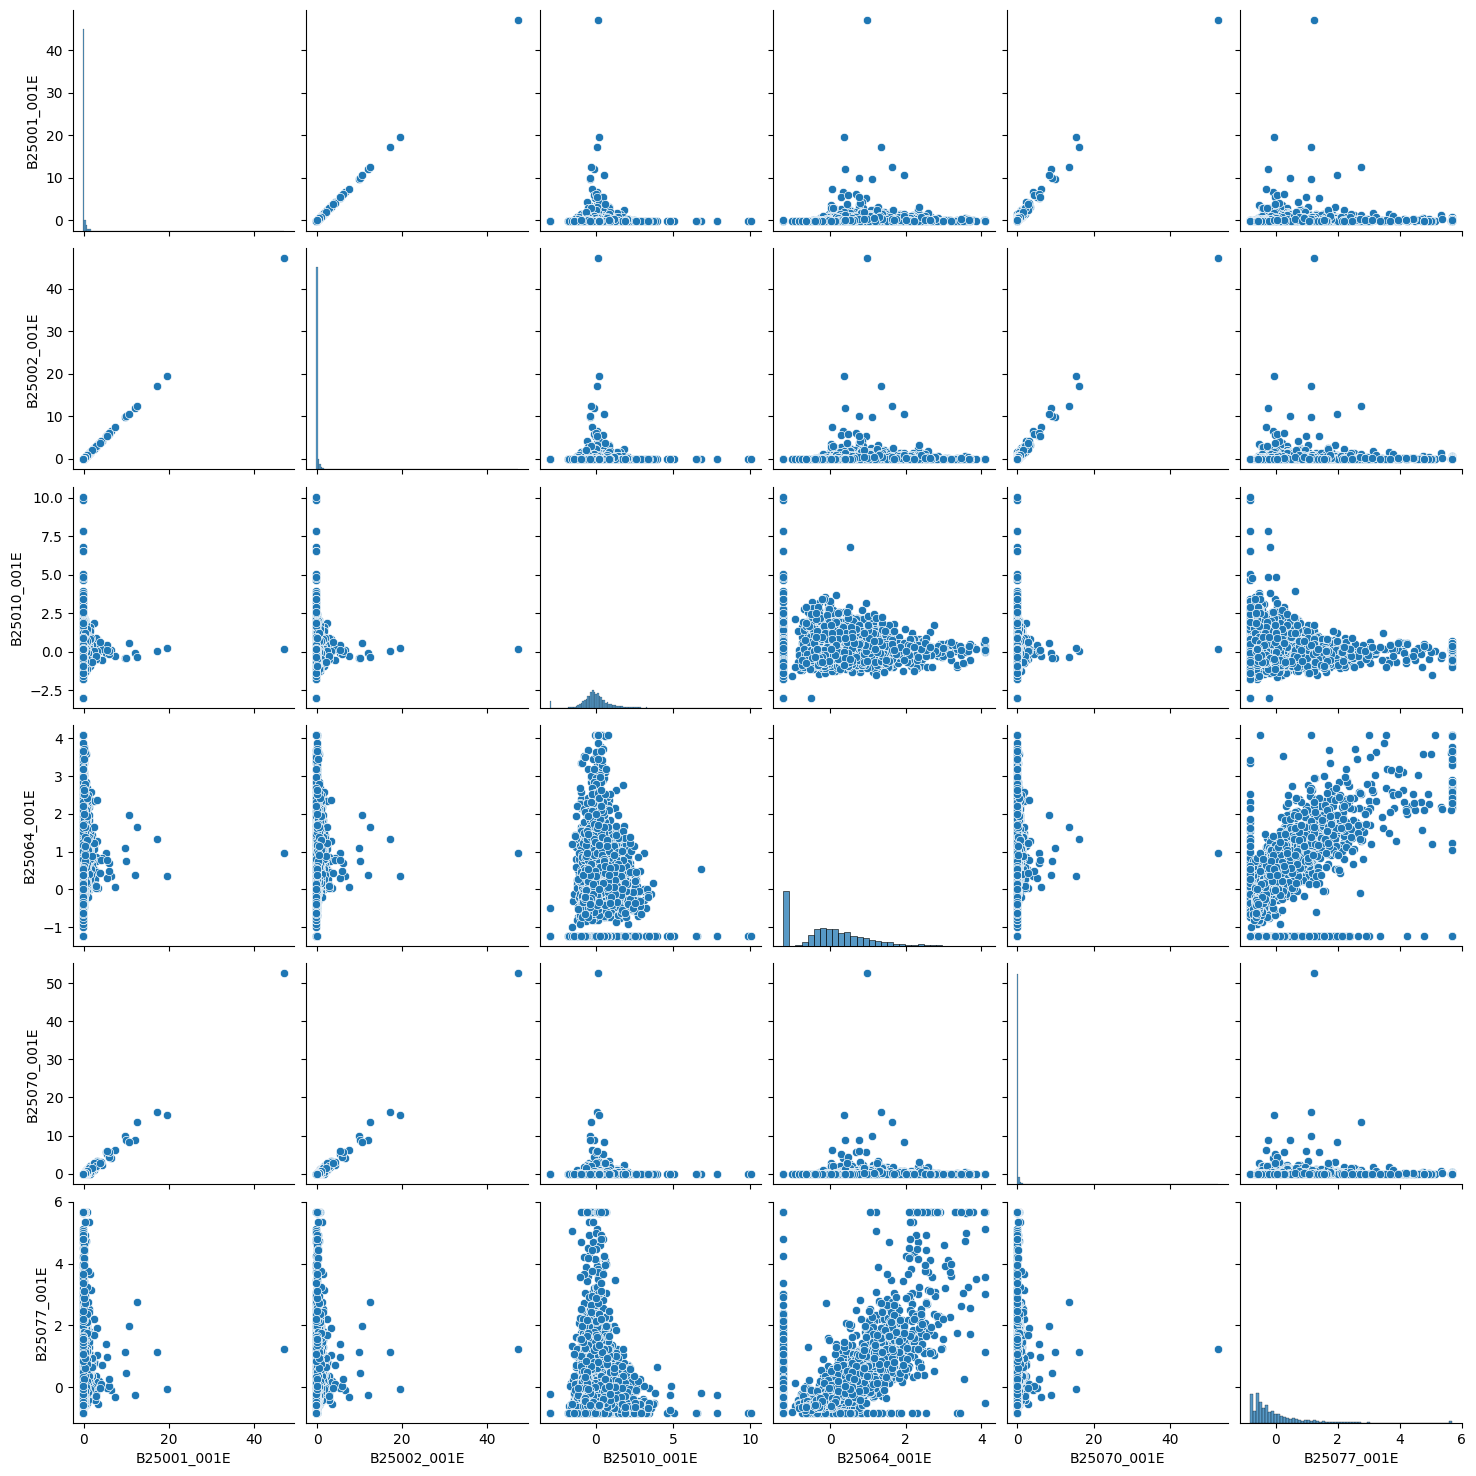

In [24]:
pairplot(estimates_df_normscaled, housing_features)

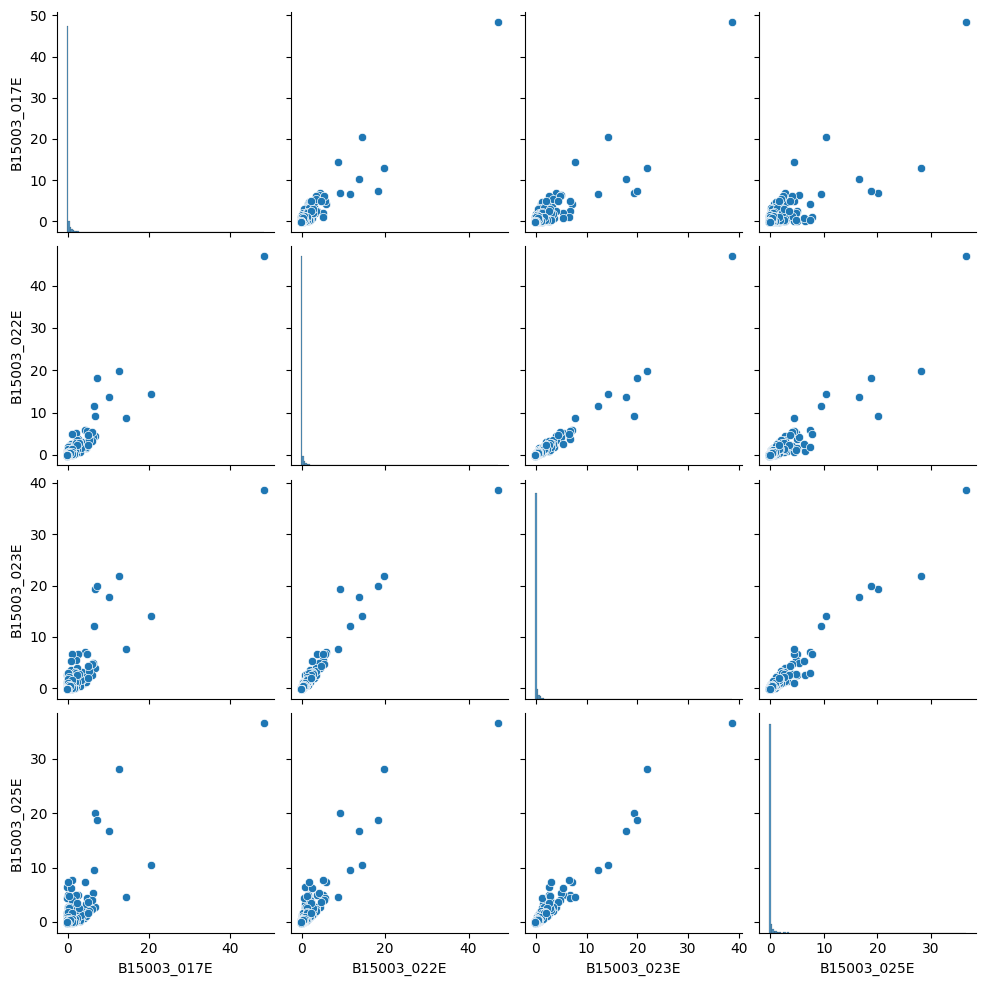

In [25]:
pairplot(estimates_df_normscaled, education_features)

### State Profiles
The following is a deepdive into each available state and how they "perform" in each variable.

In [26]:
from empowered.models.sql.schemas import CensusVariable

variables_df = pd.DataFrame(sql_client.select(CensusVariable))
variables_df['simple_name'] = variables_df['description'].apply(
    lambda x: " - ".join(x.replace(':', '!!').split('!!')[-2:]).strip()
)
variables_df.tail()

,id,dataset_id,year_id,description,group_id,simple_name
703,B25070_011MA,acs5,1,Annotation of Margin of Error!!Total:!!Not com...,B25070,- Not computed
704,B25077_001E,acs5,1,Estimate!!Median value (dollars),B25077,Estimate - Median value (dollars)
705,B25077_001EA,acs5,1,Annotation of Estimate!!Median value (dollars),B25077,Annotation of Estimate - Median value (dollars)
706,B25077_001M,acs5,1,Margin of Error!!Median value (dollars),B25077,Margin of Error - Median value (dollars)
707,B25077_001MA,acs5,1,Annotation of Margin of Error!!Median value (d...,B25077,Annotation of Margin of Error - Median value (...


In [27]:
estimates_df_normscaled_geo = estimates_df_normscaled.copy()

estimates_df_normscaled_geo['state_fips'] = estimates_df['state_fips']
estimates_df_normscaled_geo['place_fips'] = estimates_df['place_fips']

In [28]:
estimates_df_normscaled_geo.head()

,B14007_005E,B17001_049E,B15003_018E,B19001_016E,B17001_024E,B17001_027E,B09010_010E,B15003_022E,B14006_004E,B17001_058E,...,B14006_005E,B14006_015E,B19001_007E,B19013_001E,B25070_007E,B17001_046E,B09010_011E,B15003_007E,state_fips,place_fips
0,-0.162989,-0.170067,-0.176246,-0.172765,-0.516627,0.385979,0.286858,-0.152958,-0.342595,-0.187910,...,0.967072,-0.164982,-0.156528,-0.799647,-0.119427,-0.169563,0.529817,-0.084716,1,9424
1,-0.770500,-0.193786,-0.198766,-0.125918,-0.516627,-0.474933,-0.779312,-0.122253,-0.342595,-0.127593,...,-0.394183,-0.685951,-0.119515,0.315091,-0.126692,-0.161040,-0.160684,-0.084716,4,75940
2,-0.474130,-0.184207,-0.192761,-0.167904,-0.516627,-0.054943,-0.938185,-0.140996,-0.342595,-0.138947,...,-0.394183,-0.685951,-0.121124,-0.325137,-0.126692,-0.167484,-0.532868,-0.084716,4,70040
3,0.252112,0.188448,0.134528,-0.066255,0.497268,0.004094,0.418583,-0.082176,0.329213,0.045909,...,0.092381,0.369624,0.264296,-0.367394,0.073418,0.084208,0.471279,0.165944,6,70882
4,-0.770500,-0.188312,-0.212278,-0.171439,0.372423,1.007571,-1.411683,-0.151587,-0.342595,-0.203167,...,-0.394183,-0.685951,-0.161356,-0.424967,-0.126692,-0.177551,-0.532868,-0.084716,5,29140


In [29]:
tmp_geo = estimates_df_normscaled_geo.melt(
    id_vars=['state_fips'],   # columns to keep
    var_name='id',            # column for variable IDs
    value_name='value'        # column for values
)

# Merge with variable descriptions
tmp_geo = tmp_geo.merge(variables_df, on='id', how='left')

tmp_geo.head()

,state_fips,id,value,dataset_id,year_id,description,group_id,simple_name
0,1,B14007_005E,-0.162989,acs5,1.0,Estimate!!Total:!!Enrolled in school:!!Enrolle...,B14007,- Enrolled in grade 1
1,4,B14007_005E,-0.770500,acs5,1.0,Estimate!!Total:!!Enrolled in school:!!Enrolle...,B14007,- Enrolled in grade 1
2,4,B14007_005E,-0.474130,acs5,1.0,Estimate!!Total:!!Enrolled in school:!!Enrolle...,B14007,- Enrolled in grade 1
3,6,B14007_005E,0.252112,acs5,1.0,Estimate!!Total:!!Enrolled in school:!!Enrolle...,B14007,- Enrolled in grade 1
4,5,B14007_005E,-0.770500,acs5,1.0,Estimate!!Total:!!Enrolled in school:!!Enrolle...,B14007,- Enrolled in grade 1


In [30]:
descriptive_geo = estimates_df_normscaled_geo.copy()

In [31]:
id_to_desc = dict(zip(variables_df['id'], variables_df['simple_name']))
descriptive_geo.rename(columns=id_to_desc, inplace=True)
descriptive_geo.head()

,- Enrolled in grade 1,- 6 to 11 years,- GED or alternative credential,"- $150,000 to $199,999",- 18 to 24 years,- 45 to 54 years,- In married-couple family,- Bachelor's degree,"- Enrolled in nursery school, preschool",- 65 to 74 years,...,- Enrolled in kindergarten,- Enrolled in kindergarten,"- $30,000 to $34,999",Estimate - Median household income in the past 12 months (in 2019 inflation-adjusted dollars),- 30.0 to 34.9 percent,Female -,"- In male householder, no spouse present, family",- 3rd grade,state_fips,place_fips
0,-0.162989,-0.170067,-0.176246,-0.172765,-0.516627,0.385979,0.286858,-0.152958,-0.342595,-0.187910,...,0.967072,-0.164982,-0.156528,-0.799647,-0.119427,-0.169563,0.529817,-0.084716,1,9424
1,-0.770500,-0.193786,-0.198766,-0.125918,-0.516627,-0.474933,-0.779312,-0.122253,-0.342595,-0.127593,...,-0.394183,-0.685951,-0.119515,0.315091,-0.126692,-0.161040,-0.160684,-0.084716,4,75940
2,-0.474130,-0.184207,-0.192761,-0.167904,-0.516627,-0.054943,-0.938185,-0.140996,-0.342595,-0.138947,...,-0.394183,-0.685951,-0.121124,-0.325137,-0.126692,-0.167484,-0.532868,-0.084716,4,70040
3,0.252112,0.188448,0.134528,-0.066255,0.497268,0.004094,0.418583,-0.082176,0.329213,0.045909,...,0.092381,0.369624,0.264296,-0.367394,0.073418,0.084208,0.471279,0.165944,6,70882
4,-0.770500,-0.188312,-0.212278,-0.171439,0.372423,1.007571,-1.411683,-0.151587,-0.342595,-0.203167,...,-0.394183,-0.685951,-0.161356,-0.424967,-0.126692,-0.177551,-0.532868,-0.084716,5,29140


In [32]:
agg_funcs = ['mean', 'std', 'min', 'median', 'max']
percentiles = [lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]

def custom_agg(x):
    return pd.Series({
        'mean': x.mean(),
        'std': x.std(),
        'min': x.min(),
        '25%': np.percentile(x, 25),
        '50%': np.median(x),
        '75%': np.percentile(x, 75),
        'max': x.max()
    })

In [33]:
state_profile = descriptive_geo.groupby('state_fips').apply(lambda g: g.apply(custom_agg))
state_profile

/tmp/ipykernel_181587/3328186249.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_profile = descriptive_geo.groupby('state_fips').apply(lambda g: g.apply(custom_agg))


- Enrolled in grade 1  - 6 to 11 years  \
state_fips                                                
1          mean               0.062827        -0.125223   
           std                0.958879         0.221580   
           min               -0.770500        -0.193786   
           25%               -0.770500        -0.191505   
           50%               -0.076478        -0.181927   
...                                ...              ...   
12         min               -0.770500        -0.193786   
           25%               -0.559070        -0.176453   
           50%               -0.169801        -0.127419   
           75%                0.172372         0.024698   
           max                3.101927        11.531383   

                 - GED or alternative credential  - $150,000 to $199,999  \
state_fips                                                                 
1          mean                        -0.084559               -0.128277   
           std                          0.400670                0.175767   
           min                         -0.214530               -0.172765   
           25%                         -0.204021               -0.172765   
           50%                         -0.178874               -0.169229   
...                                          ...                     ...   
12         min                         -0.214530               -0.172765   
           25%                         -0.167426               -0.165362   
           50%                         -0.065899               -0.113765   
           75%                          0.158925               -0.008138   
           max                         19.775640                6.911260   

                 - 18 to 24 years  - 45 to 54 years  \
state_fips                                            
1          mean          0.062370          0.097078   
           std           0.893741          0.988465   
           min          -0.516627         -0.474933   
           25%          -0.516627         -0.474933   
           50%          -0.232286         -0.108902   
...                           ...               ...   
12         min          -0.516627         -0.474933   
           25%          -0.516627         -0.294037   
           50%          -0.260077         -0.113862   
           75%           0.107272          0.081747   
           max           5.356114          2.888310   

                 - In married-couple family  - Bachelor's degree  \
state_fips                                                         
1          mean                    0.020368            -0.102920   
           std                     0.933070             0.205182   
           min                    -1.411683            -0.153492   
           25%                    -0.606421            -0.151892   
           50%                    -0.074758            -0.147968   
...                                     ...                  ...   
12         min                    -1.411683            -0.153492   
           25%                    -0.666273            -0.137663   
           50%                    -0.279839            -0.069414   
           75%                     0.135574             0.044208   
           max                     3.065553             8.662878   

                 - Enrolled in nursery school, preschool  - 65 to 74 years  \
state_fips                                                                   
1          mean                                -0.025472         -0.117039   
           std                                  0.996405          0.279225   
           min                                 -0.342595         -0.203522   
           25%                                 -0.342595         -0.197490   
           50%                                 -0.342595         -0.185072   
...                                                  ...               ...   
12         min                     

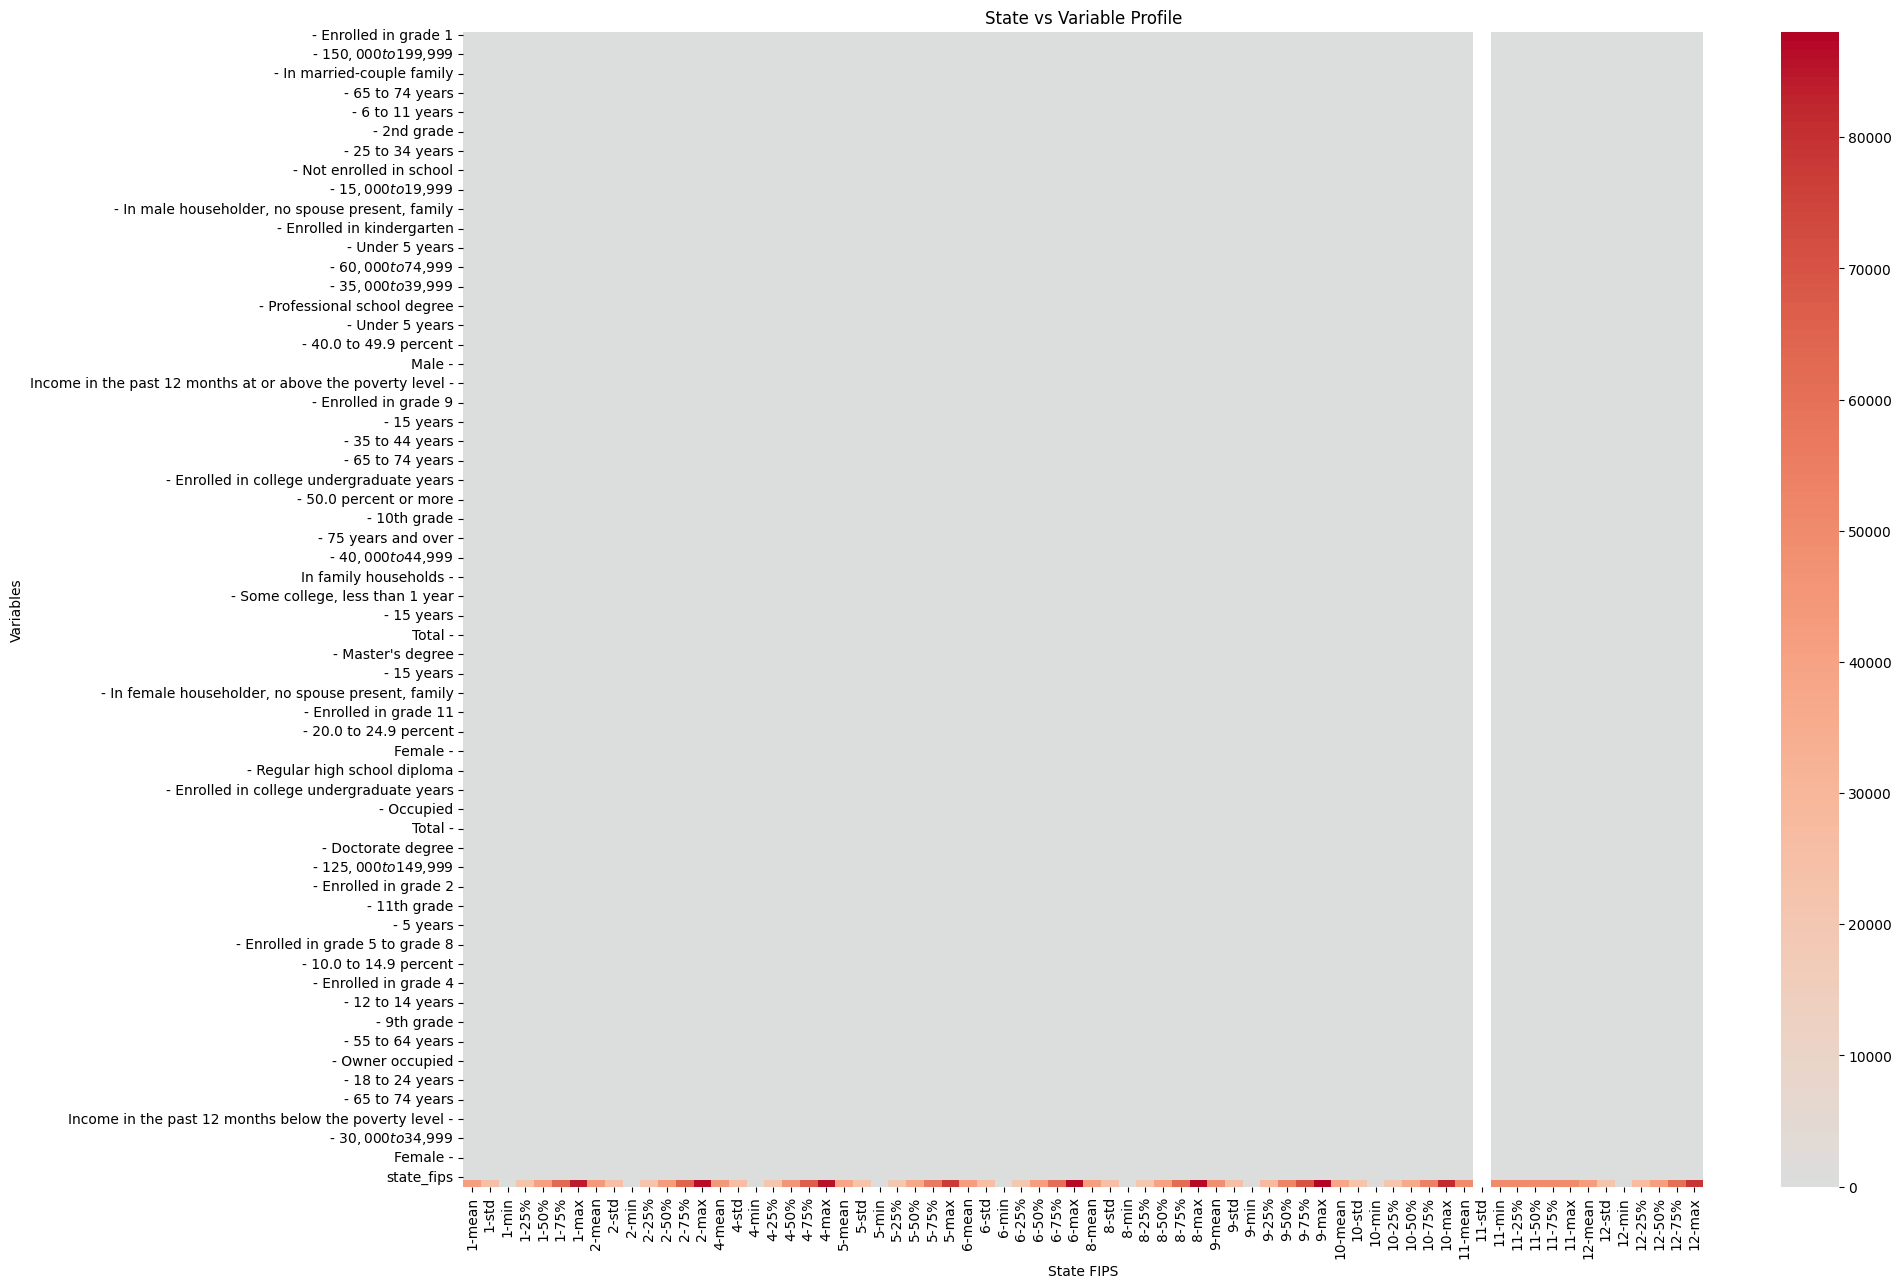

In [34]:
plt.figure(figsize=(20, 15))
sns.heatmap(state_profile.T, cmap='coolwarm', center=0)
plt.title("State vs Variable Profile")
plt.xlabel("State FIPS")
plt.ylabel("Variables")
plt.show()

In [35]:
for i in set(estimates_df['state_fips']):
    print(f"=============================== State FIPS: {i} ==============================")
    print(state_profile.loc[i])
    print("\n")

=============================== State FIPS: 1 ==============================
      - Enrolled in grade 1  - 6 to 11 years  - GED or alternative credential  \
mean               0.062827        -0.125223                        -0.084559   
std                0.958879         0.221580                         0.400670   
min               -0.770500        -0.193786                        -0.214530   
25%               -0.770500        -0.191505                        -0.204021   
50%               -0.076478        -0.181927                        -0.178874   
75%                0.412570        -0.147831                        -0.114880   
max               10.515420         2.369641                         4.664032   

      - $150,000 to $199,999  - 18 to 24 years  - 45 to 54 years  \
mean               -0.128277          0.062370          0.097078   
std                 0.175767          0.893741          0.988465   
min                -0.172765         -0.516627         -0.474933   
25

# State-by-State Analysis of Descriptive Statistics (FIPS 1–12)
# **FIPS 1 → Alabama**

## Overall Profile
Alabama shows **lower-than-average socioeconomic conditions**, with reduced income, bachelor’s attainment, and fewer high-income households.

## Key Findings
- **Median household income:** -0.29 → notably below national average  
- **Bachelor’s degree:** -0.10 → slightly lower educational attainment  
- **High income ($150k–199k):** -0.13 → fewer high-income households  
- **GED / alternative credential:** slightly elevated  
- **Female population share:** slightly low  
- **Age groups:** 18–24, 45–54, 65–74 all slightly below average  

## Interpretation
Alabama represents a **lower-income, slightly older, modest-education** state with a limited concentration of high-wage households.

---

# **FIPS 2 → Alaska**

## Overall Profile
Alaska shows **wide variability** due to small populations, moderate income, and strong youth enrollment.

## Key Findings
- **Nursery school enrollment:** high (+0.25) → younger demographic  
- **Married-couple families:** -0.17 → fewer traditional households  
- **GED rates:** highly variable; rural influence  
- **Median income:** -0.32 → lower than expected for Alaska  
- **Age groups:** strong dispersion across categories  
- **Education:** slightly below average but extremely variable  

## Interpretation
Alaska reflects **extreme demographic variation**, with younger populations in some places and significant rural influence on income and education levels.

---

# **FIPS 4 → Arizona**

## Overall Profile
Arizona trends toward **lower incomes**, **mixed educational attainment**, and a **larger youth population**.

## Key Findings
- **Median income:** -0.45 → substantially below national average  
- **Bachelor’s degree:** around the national average but highly variable  
- **Age 6–11 / nursery / kindergarten:** generally above average → more children  
- **GED:** slightly elevated  
- **$150k–199k households:** below average  

## Interpretation
Arizona is characterized by **lower incomes**, a **younger population**, and significant differences between urban centers and rural areas.

---

# **FIPS 5 → Arkansas**

## Overall Profile
Arkansas shows **lower educational attainment**, **lower income**, and stronger representation of single-parent households.

## Key Findings
- **Median income:** -0.40 → lower-income state  
- **Bachelor’s degree:** -0.12 → below national norms  
- **Nursery school enrollment:** high (+0.24)  
- **Age 18–24 & 45–54:** slightly above average  
- **GED:** somewhat elevated  

## Interpretation
Arkansas appears to be a **working-class state** with young families, lower education levels, and moderate economic challenges.

---

# **FIPS 6 → California**

## Overall Profile
California displays **extreme highs and lows** due to enormous population diversity. Overall: **higher income, higher education, large family and age-group variability**.

## Key Findings
- **Median income:** +0.32 → above national average  
- **Bachelor’s degree:** +0.11, with **max = 47 (!) → elite educational centers**  
- **$150k–199k income:** elevated  
- **Child age groups:** very high maxima → large population centers  
- **Female percentage:** slightly above average  
- **3rd grade / male head-of-household:** extreme maxima → large urban variation  

## Interpretation
California exhibits **strong economic and educational peaks** along with substantial inequality, producing enormous statistical spread.

---

# **FIPS 8 → Colorado**

## Overall Profile
Colorado trends toward **higher income**, **family-oriented populations**, and moderate education levels.

## Key Findings
- **Median income:** +0.14 → above average  
- **Married-couple family rate:** +0.26 → strong family structure  
- **Bachelor’s degree:** slightly below national average (surprisingly)  
- **Female population:** average  
- **Kindergarten:** slightly below average  

## Interpretation
Colorado appears to be a **higher-income, family-centered** state with educational attainment influenced by both urban and rural municipalities.

---

# **FIPS 9 → Connecticut**

## Overall Profile
Connecticut stands out as a **wealthy, suburban-leaning state** with strong income levels and moderate education.

## Key Findings
- **Median income:** +0.74 → significantly above national  
- **$150k–199k households:** slightly above norm  
- **Bachelor’s degree:** near national average  
- **Children (K–6):** slightly lower enrollment  
- **Female population:** near national average  

## Interpretation
Connecticut shows the profile of a **high-income, mature suburban population** with balanced educational outcomes.

---

# **FIPS 10 → Delaware**

## Overall Profile
Delaware displays **moderate-to-high income**, slightly lower education, and a somewhat older demographic.

## Key Findings
- **Median income:** +0.36 → above average  
- **Bachelor’s degree:** -0.10 → slightly below US norm  
- **Age groups:** somewhat older than average  
- **Children (grade 1 & K):** below average  

## Interpretation
Delaware has a **stable, modestly affluent** population profile with slightly lower-than-average educational attainment.

---

# **FIPS 11 → District of Columbia (Washington, D.C.)**

## Overall Profile
DC has **single-record data**, meaning all values appear as extreme standardized scores due to being compared to the entire nation.

## Key Findings (All Extremely High or Unique)
- **Bachelor’s degree:** 9.17 → extremely above average  
- **Income $150k–199k:** 12.24 → extremely high  
- **GED:** 9.63 → highly elevated  
- **Female population:** 8.30 → very high  
- **Age categories:** large positive deviations  

## Interpretation
DC is a statistical outlier due to:  
- **high education**,  
- **high incomes**,  
- **extreme demographic concentration**,  
and being **one city** compared against thousands of places.

---

# **FIPS 12 → Florida**

## Overall Profile
Florida shows **mixed socioeconomic patterns**, including a large elderly population, moderate education levels, and moderate income.

## Key Findings
- **Median income:** +0.077 → slightly above average  
- **Bachelor’s degree:** +0.07 → slightly above average  
- **Age 65–74:** +0.196 → supports Florida’s retirement trends  
- **GED:** high (mean = 0.21)  
- **Female population:** above average  
- **Children’s enrollment:** mixed, some below average  

## Interpretation
Florida reflects:  
- **large senior population**,  
- **middle-income economy**,  
- **modest education levels**,  
with strong variability across urban, suburban, and rural municipalities.

---


## Modeling

### PCA

In [36]:
pca = PCA(10)
estimates_pca = pca.fit_transform(estimates_df_normscaled)

In [37]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.47174364, 0.08504883, 0.05714802, 0.02678085, 0.01807715,
       0.01476429, 0.01381588, 0.01251763, 0.01096015, 0.01078733])

In [38]:
sum(explained_variance)

np.float64(0.721643779742964)

In [51]:
loadings = pca.components_

In [60]:
loadings_df = pd.DataFrame(
    pca.components_,
    columns=estimates_df_normscaled.columns,           
    index=[f"PC{i}" for i in range(1, 11)] 
)

print(loadings_df.loc[["PC1", "PC2"]])

     B14007_005E  B17001_049E  B15003_018E  B19001_016E  B17001_024E  \
PC1     0.001279     0.107275     0.099093     0.104044     0.001339   
PC2     0.072921    -0.000382     0.003779    -0.009758     0.084848   

     B17001_027E  B09010_010E  B15003_022E  B14006_004E  B17001_058E  ...  \
PC1    -0.002516     0.005169     0.106611    -0.001247     0.107645  ...   
PC2     0.070547    -0.013296    -0.006998     0.106339    -0.006504  ...   

     B17001_020E  B14006_002E  B14006_005E  B14006_015E  B19001_007E  \
PC1    -0.001807    -0.004181    -0.000874     0.002746     0.107485   
PC2     0.168651     0.218632     0.121206     0.010003     0.004285   

     B19013_001E  B25070_007E  B17001_046E  B09010_011E  B15003_007E  
PC1     0.009665     0.108114     0.109088     0.000893     0.097794  
PC2    -0.091184     0.003074    -0.001763     0.025611     0.010396  

[2 rows x 177 columns]


No individual nor combination of components  explain over 80% of the variance, so there is no gain from reducing

In [ ]:
pc1_top = loadings_df.loc["PC1"].abs().sort_values(ascending=False).head(15)
print("Top PC1 variables:\n", pc1_top)

pc2_top = loadings_df.loc["PC2"].abs().sort_values(ascending=False).head(15)
print("\nTop PC2 variables:\n", pc2_top)

Top PC1 variables:
 B01003_001E    0.109319
B15003_001E    0.109317
B17001_031E    0.109099
B17001_032E    0.109091
B17001_046E    0.109088
B19001_001E    0.109071
B25002_002E    0.109071
B17001_041E    0.108923
B25002_001E    0.108921
B25001_001E    0.108921
B17001_042E    0.108919
B17001_055E    0.108855
B17001_056E    0.108838
B17001_057E    0.108710
B17001_043E    0.108671
Name: PC1, dtype: float64

Top PC2 variables:
 B14006_003E    0.225347
B17001_002E    0.222878
B14006_002E    0.218632
B09010_002E    0.208202
B09010_003E    0.207991
B17001_017E    0.202732
B17001_003E    0.197511
B14006_006E    0.190675
B14006_007E    0.178150
B09010_006E    0.171559
B17001_020E    0.168651
B09010_001E    0.165584
B14006_011E    0.165015
B17001_006E    0.164601
B14006_021E    0.156176
Name: PC2, dtype: float64


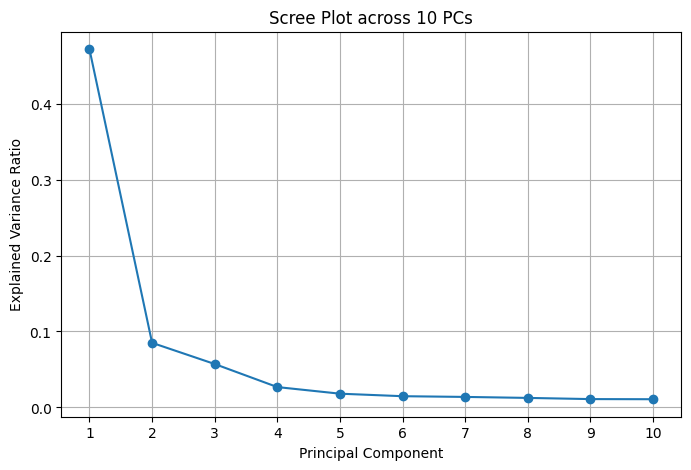

In [39]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title("Scree Plot across 10 PCs")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance)+1))
plt.grid(True)
plt.show()

### K Means Clustering

In [40]:
k = 3 # Initial hypothesis, that cities can be grouped into low, middle, and high socioeconomic status

In [41]:
kmeans = KMeans(n_clusters=k, random_state=42)

In [42]:
kmeans.fit(estimates_df_normscaled)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [43]:
labels = kmeans.labels_
labels

array([0, 1, 1, ..., 1, 0, 1], shape=(4287,), dtype=int32)

In [44]:
centroids = kmeans.cluster_centers_
centroids

array([[ 2.60337807e-01, -1.49062443e-01, -1.36820636e-01,
        -1.60124844e-01,  4.84890518e-01,  4.01006874e-01,
        -2.69465877e-01, -1.40282510e-01,  5.53834563e-01,
        -1.63286843e-01,  6.85435405e-02,  2.04936163e-01,
        -1.48118629e-01,  4.09370291e-01, -9.66614846e-02,
        -3.95400585e-02, -5.14821779e-02, -1.39432435e-01,
         7.79941953e-01, -9.72065101e-02, -1.23928087e-01,
         9.61989446e-01, -2.13089328e-01, -1.37006245e-01,
        -9.36571975e-02,  3.91899303e-01,  6.56188775e-01,
         4.65067434e-01,  8.60126834e-02, -1.50793648e-01,
         2.81804212e-01,  1.94911895e-01, -9.41285448e-02,
         7.35705959e-01,  6.96205243e-01, -1.05703743e-01,
        -1.38279811e-01, -1.20397105e-01, -1.54343562e-01,
        -1.15727764e-01, -2.74663325e-01, -7.83600656e-02,
        -1.25381357e-01,  7.03828063e-01, -1.39530512e-01,
        -1.39666142e-01, -1.28359267e-01, -1.40000461e-01,
        -9.21457041e-02,  1.38090208e-01,  1.21722126e+0

#### Cluster Plot

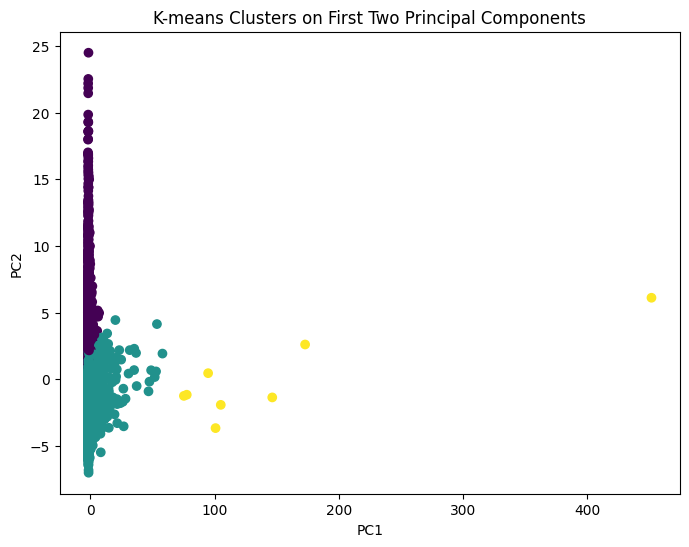

In [45]:
PC1 = estimates_pca[:, 0]
PC2 = estimates_pca[:, 1]
plt.figure(figsize=(8,6))
plt.scatter(PC1, PC2, c=labels, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means Clusters on First Two Principal Components")
plt.show()

In [47]:
estimates_df_normscaled["place_state_fips"] = (
    estimates_df["place_fips"].astype(str)
    + "_"
    + estimates_df["state_fips"].astype(str)
)
estimates_df_normscaled = estimates_df_normscaled.set_index("place_state_fips")


In [48]:
df_pca = pd.DataFrame({
    "PC1": PC1,
    "PC2": PC2,
    "Cluster": labels,
    "Index": estimates_df_normscaled.index,
})

fig = px.scatter(df_pca, x="PC1", y="PC2", color="Cluster", hover_data=["Index"])

In [49]:
fig.show()

#### Cluster Analysis
Lets see the cluster performance across different k.

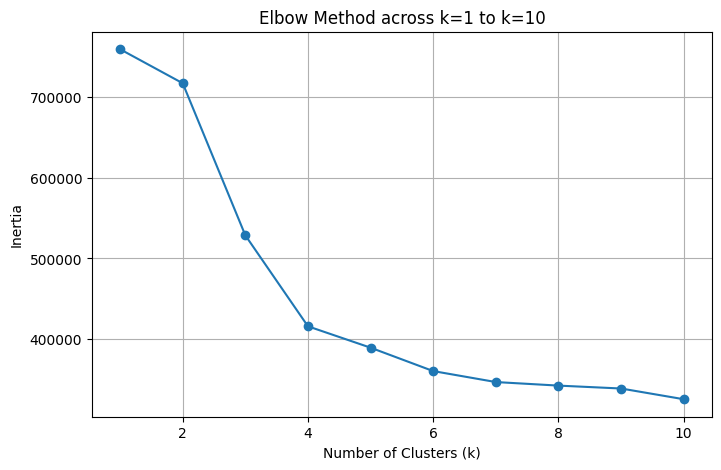

In [62]:
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(estimates_df_normscaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, 'o-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method across k=1 to k=10")
plt.grid(True)
plt.show()

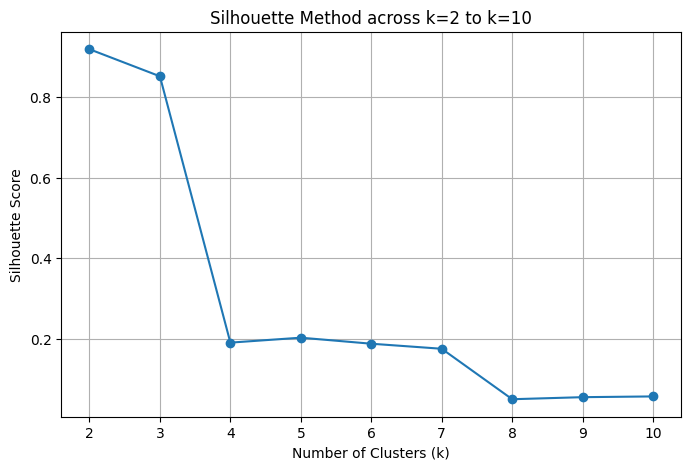

In [63]:
silhouette_scores = []
K = range(2, 11)  

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(estimates_df_normscaled)
    score = silhouette_score(estimates_df_normscaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, 'o-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method across k=2 to k=10")
plt.grid(True)
plt.show()

Given the Elbow and Silhouette methods we can see k=3 is the optimal cluster amount, which follows our expectation.

In [68]:
estimates_df_normscaled["cluster"] = labels
estimates_df_normscaled["place_fips"] = estimates_df.set_index(estimates_df_normscaled.index)["place_fips"]
estimates_df_normscaled["state_fips"] = estimates_df.set_index(estimates_df_normscaled.index)["state_fips"]

In [71]:
cluster_map = {
    0: "Low SES",
    1: "Middle SES",
    2: "High SES"
}

estimates_df_normscaled["SES_tier"] = estimates_df_normscaled["cluster"].map(cluster_map)

In [ ]:
estimates_df_normscaled

,B14007_005E,B17001_049E,B15003_018E,B19001_016E,B17001_024E,B17001_027E,B09010_010E,B15003_022E,B14006_004E,B17001_058E,...,B19001_007E,B19013_001E,B25070_007E,B17001_046E,B09010_011E,B15003_007E,cluster,place_fips,state_fips,SES_tier
place_state_fips,,,,,,,,,,,,,,,,,,,,,
9424_1,-0.162989,-0.170067,-0.176246,-0.172765,-0.516627,0.385979,0.286858,-0.152958,-0.342595,-0.187910,...,-0.156528,-0.799647,-0.119427,-0.169563,0.529817,-0.084716,0,9424,1,Low SES
75940_4,-0.770500,-0.193786,-0.198766,-0.125918,-0.516627,-0.474933,-0.779312,-0.122253,-0.342595,-0.127593,...,-0.119515,0.315091,-0.126692,-0.161040,-0.160684,-0.084716,1,75940,4,Middle SES
70040_4,-0.474130,-0.184207,-0.192761,-0.167904,-0.516627,-0.054943,-0.938185,-0.140996,-0.342595,-0.138947,...,-0.121124,-0.325137,-0.126692,-0.167484,-0.532868,-0.084716,1,70040,4,Middle SES
70882_6,0.252112,0.188448,0.134528,-0.066255,0.497268,0.004094,0.418583,-0.082176,0.329213,0.045909,...,0.264296,-0.367394,0.073418,0.084208,0.471279,0.165944,0,70882,6,Low SES
29140_5,-0.770500,-0.188312,-0.212278,-0.171439,0.372423,1.007571,-1.411683,-0.151587,-0.342595,-0.203167,...,-0.161356,-0.424967,-0.126692,-0.177551,-0.532868,-0.084716,0,29140,5,Low SES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16644_6,-0.770500,-0.193786,-0.214530,-0.172765,-0.516627,5.319187,-1.411683,-0.153492,-0.342595,-0.203522,...,-0.167793,-1.458318,-0.126692,-0.178917,-0.532868,-0.084716,1,16644,6,Middle SES
67940_5,0.286915,-0.190137,-0.176997,-0.172765,1.409010,0.167272,-0.474711,-0.153111,0.663771,-0.196426,...,-0.163770,-0.582960,-0.115465,-0.173690,0.018589,-0.084716,0,67940,5,Low SES
51140_6,0.815029,0.166097,-0.076408,-0.120173,-0.053444,0.078009,0.783855,-0.103967,-0.342595,-0.084306,...,-0.035028,0.222290,-0.074518,-0.019011,0.443126,-0.064442,1,51140,6,Middle SES


In [74]:
state_tier_counts = estimates_df_normscaled.groupby(["state_fips", "SES_tier"]).size()
state_tier_counts

state_fips  SES_tier  
1           Low SES        203
            Middle SES     383
2           Low SES        126
            Middle SES     228
4           High SES         1
            Low SES        170
            Middle SES     279
5           Low SES        218
            Middle SES     322
6           High SES         4
            Low SES        300
            Middle SES    1217
8           High SES         1
            Low SES         62
            Middle SES     396
9           Low SES          8
            Middle SES     135
10          Low SES         14
            Middle SES      63
11          High SES         1
12          High SES         1
            Low SES         29
            Middle SES     126
dtype: int64